In [173]:
import pandas as pd
import numpy as np

# Load cardio activities data
cardio_data = pd.read_csv('cardioActivities.csv')

# Display the first few rows of the dataset
cardio_data.head()


,Activity Id,Date,Type,Route Name,Distance (mi),Duration,Average Pace,Average Speed (mph),Calories Burned,Climb (ft),Average Heart Rate (bpm),Friend's Tagged,Notes,GPX File
0,1fd0d33a-49a2-4da2-9292-02f831b3a5e3,6/20/2024 19:48,Running,NaN,2.01,18:52,9:23,6.40,300.0,78,157.0,NaN,NaN,2024-06-20-194818.gpx
1,065d77ca-8413-4bb2-8f30-a1cf9753e15c,6/19/2024 12:56,Running,NaN,2.15,22:34,10:29,5.73,322.0,151,160.0,NaN,NaN,2024-06-19-125649.gpx
2,43e8964a-646b-4f9f-b432-a56ae9207db0,6/16/2024 17:51,Running,NaN,2.01,19:41,9:49,6.11,295.0,77,144.0,NaN,NaN,2024-06-16-175103.gpx
3,8df01142-e1be-4af4-b5bd-3a1b489e50a8,6/14/2024 17:49,Walking,NaN,0.70,22:52,32:31:00,1.85,84.0,0,NaN,NaN,NaN,NaN
4,f413a03a-8478-4fb7-a2d9-ff136385119f,6/14/2024 14:03,Walking,NaN,0.55,20:05,36:46:00,1.63,68.0,0,NaN,NaN,NaN,NaN


In [174]:
# Filter data to include only running activities
running_data = cardio_data[cardio_data['Type'] == 'Running'].copy()

# Drop non-critical columns with many missing values
running_data.drop(columns=["Route Name", "Friend's Tagged", "Notes"], inplace=True)


In [175]:
# Function to convert 'minutes:seconds' to total seconds
def pace_to_seconds(pace):
    if pd.isna(pace):
        return None
    minutes, seconds = pace.split(':')
    return int(minutes) * 60 + int(seconds)

# Apply the conversion to 'Average Pace'
running_data['Average Pace (seconds)'] = running_data['Average Pace'].apply(pace_to_seconds)

# Impute missing values
mean_pace = running_data['Average Pace (seconds)'].mean()
running_data['Average Pace (seconds)'] = running_data['Average Pace (seconds)'].fillna(mean_pace)
mean_speed = running_data['Average Speed (mph)'].mean()
running_data['Average Speed (mph)'] = running_data['Average Speed (mph)'].fillna(mean_speed)
mean_hr = running_data['Average Heart Rate (bpm)'].mean()
running_data['Average Heart Rate (bpm)'] = running_data['Average Heart Rate (bpm)'].fillna(mean_hr)

# Check the result
running_data.head()


,Activity Id,Date,Type,Distance (mi),Duration,Average Pace,Average Speed (mph),Calories Burned,Climb (ft),Average Heart Rate (bpm),GPX File,Average Pace (seconds)
0,1fd0d33a-49a2-4da2-9292-02f831b3a5e3,6/20/2024 19:48,Running,2.01,18:52,9:23,6.40,300.000,78,157.000000,2024-06-20-194818.gpx,563.0
1,065d77ca-8413-4bb2-8f30-a1cf9753e15c,6/19/2024 12:56,Running,2.15,22:34,10:29,5.73,322.000,151,160.000000,2024-06-19-125649.gpx,629.0
2,43e8964a-646b-4f9f-b432-a56ae9207db0,6/16/2024 17:51,Running,2.01,19:41,9:49,6.11,295.000,77,144.000000,2024-06-16-175103.gpx,589.0
5,ef26ae07-5f8e-4c2e-a959-a41526587244,6/13/2024 16:25,Running,2.02,20:25,10:06,5.94,247.301,339,155.000000,2024-06-13-162553.gpx,606.0
6,f9d37406-d622-43dc-8813-bc0059b2a5de,6/13/2024 16:25,Running,2.11,24:06:00,11:25,5.25,315.000,82,156.681818,2024-06-13-162503.gpx,685.0


In [176]:
# Reset the index
running_data.reset_index(drop=True, inplace=True)

# Function to create synthetic data
def create_synthetic_data(df, num_samples=1000, noise_factor=0.1):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    synthetic_data = []
    for _ in range(num_samples):
        sample = df.sample(n=1).copy()
        noise = np.random.normal(0, noise_factor, sample[numerical_cols].shape)
        synthetic_sample = sample.copy()
        synthetic_sample[numerical_cols] += noise
        synthetic_data.append(synthetic_sample)
    return pd.concat(synthetic_data, axis=0)

# Create synthetic data
synthetic_data = create_synthetic_data(running_data)

# Combine original and synthetic data
augmented_data = pd.concat([running_data, synthetic_data], axis=0).reset_index(drop=True)

# Save augmented data
augmented_data.to_csv('augmented_running_data.csv', index=False)

# Load the augmented data
running_data = pd.read_csv('augmented_running_data.csv')


In [177]:
# Feature Engineering
# Convert 'Date' column to datetime format if not already done
running_data['Date'] = pd.to_datetime(running_data['Date'])

# Extract day of the week
running_data['Day of Week'] = running_data['Date'].dt.dayofweek

# Convert distance from miles to kilometers 
running_data['Distance (km)'] = running_data['Distance (mi)'] * 1.60934

# Ensure the date is sorted by date
running_data = running_data.sort_values('Date')

# Calculate the time since the last run
running_data['Time Since Last Run'] = running_data['Date'].diff().dt.days.fillna(0).astype(int)

# Calculate rolling averages for pace and distance
running_data['Rolling Average Pace'] = running_data['Average Pace (seconds)'].rolling(window=5).mean().shift(1)
running_data['Rolling Average Distance'] = running_data['Distance (km)'].rolling(window=5).mean().shift(1)

# Drop rows where rolling averages could not be calculated
running_data = running_data.dropna(subset=['Rolling Average Pace', 'Rolling Average Distance'])

# Display the first few rows to confirm the new features
print(running_data[['Date', 'Time Since Last Run', 'Average Pace (seconds)', 'Rolling Average Pace', 'Distance (km)', 'Rolling Average Distance', 'Day of Week']].head(10))

                   Date  Time Since Last Run  Average Pace (seconds)  \
227 2023-07-27 20:29:00                    0              720.923201   
607 2023-07-27 20:29:00                    0              721.147349   
602 2023-07-27 20:29:00                    0              720.971438   
601 2023-07-27 20:29:00                    0              721.121065   
928 2023-07-27 20:29:00                    0              721.169433   
260 2023-07-27 20:29:00                    0              720.889366   
456 2023-07-27 20:29:00                    0              721.026864   
923 2023-07-27 20:29:00                    0              720.962387   
461 2023-07-27 20:29:00                    0              721.124976   
787 2023-07-27 20:29:00                    0              720.912271   

     Rolling Average Pace  Distance (km)  Rolling Average Distance  \
227            720.899140       3.519049                  3.404045   
607            720.916372       3.272326                  3.415517 

In [178]:
# Check the result 
running_data.head()

,Activity Id,Date,Type,Distance (mi),Duration,Average Pace,Average Speed (mph),Calories Burned,Climb (ft),Average Heart Rate (bpm),GPX File,Average Pace (seconds),Day of Week,Distance (km),Time Since Last Run,Rolling Average Pace,Rolling Average Distance
227,1762f194-d1b1-4be2-b7a8-dff47149765c,2023-07-27 20:29:00,Running,2.186641,25:52:00,12:01,5.208062,318.066078,112.008220,156.683715,2023-07-27-202935.gpx,720.923201,3,3.519049,0,720.899140,3.404045
607,1762f194-d1b1-4be2-b7a8-dff47149765c,2023-07-27 20:29:00,Running,2.033334,25:52:00,12:01,5.111620,317.843833,111.896712,156.473129,2023-07-27-202935.gpx,721.147349,3,3.272326,0,720.916372,3.415517
602,1762f194-d1b1-4be2-b7a8-dff47149765c,2023-07-27 20:29:00,Running,2.065411,25:52:00,12:01,4.848633,318.025711,111.976985,156.606605,2023-07-27-202935.gpx,720.971438,3,3.323948,0,720.954853,3.393368
601,1762f194-d1b1-4be2-b7a8-dff47149765c,2023-07-27 20:29:00,Running,2.226381,25:52:00,12:01,5.142175,318.094690,111.915588,156.580187,2023-07-27-202935.gpx,721.121065,3,3.583005,0,720.966137,3.433517
928,1762f194-d1b1-4be2-b7a8-dff47149765c,2023-07-27 20:29:00,Running,2.044292,25:52:00,12:01,4.621494,317.953742,111.955945,156.640525,2023-07-27-202935.gpx,721.169433,3,3.289961,0,721.037352,3.467810


In [179]:
# Save intermediate result
running_data.to_csv('feature_engineered_running_data.csv', index=False)

In [180]:
# Load the feature-engineered data
running_data = pd.read_csv('feature_engineered_running_data.csv')

# Display the first few rows to confirm loading
print(running_data.head())

                            Activity Id                 Date     Type  \
0  1762f194-d1b1-4be2-b7a8-dff47149765c  2023-07-27 20:29:00  Running   
1  1762f194-d1b1-4be2-b7a8-dff47149765c  2023-07-27 20:29:00  Running   
2  1762f194-d1b1-4be2-b7a8-dff47149765c  2023-07-27 20:29:00  Running   
3  1762f194-d1b1-4be2-b7a8-dff47149765c  2023-07-27 20:29:00  Running   
4  1762f194-d1b1-4be2-b7a8-dff47149765c  2023-07-27 20:29:00  Running   

   Distance (mi)  Duration Average Pace  Average Speed (mph)  Calories Burned  \
0       2.186641  25:52:00        12:01             5.208062       318.066078   
1       2.033334  25:52:00        12:01             5.111620       317.843833   
2       2.065411  25:52:00        12:01             4.848633       318.025711   
3       2.226381  25:52:00        12:01             5.142175       318.094690   
4       2.044292  25:52:00        12:01             4.621494       317.953742   

   Climb (ft)  Average Heart Rate (bpm)               GPX File  \
0  112.0

In [181]:
# Filter out rows where Distance (mi) is zero and Calories Burned is zero
running_data = running_data[(running_data['Distance (mi)'] > 0) & (running_data['Calories Burned'] > 0)]


In [182]:
# Save the cleaned DataFrame to a new CSV file
running_data.to_csv('cleaned_running_data.csv', index=False)

In [183]:
# Data Visualization 
import matplotlib.pyplot as plt

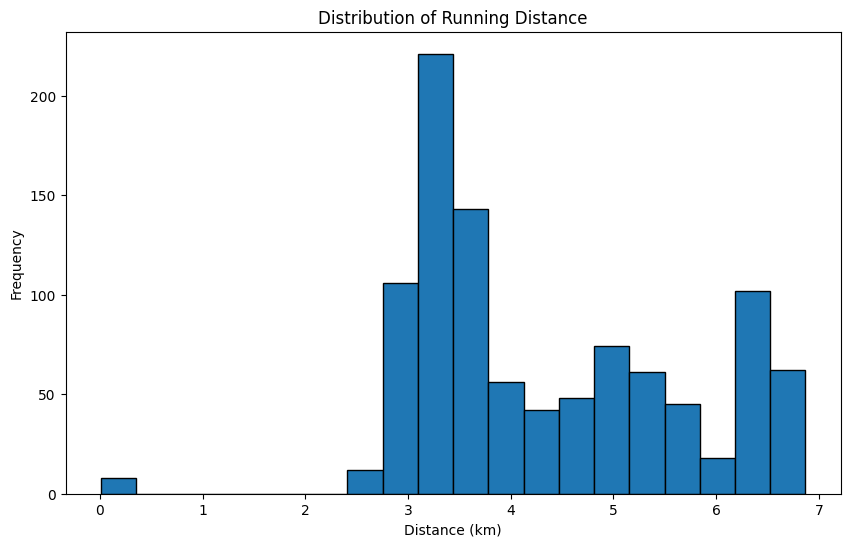

In [184]:
# Histogram of Distance (km)
# Histograms: To understand the distribution of your features.
plt.figure(figsize=(10, 6))
plt.hist(running_data['Distance (km)'], bins=20, edgecolor='k')
plt.title('Distribution of Running Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()

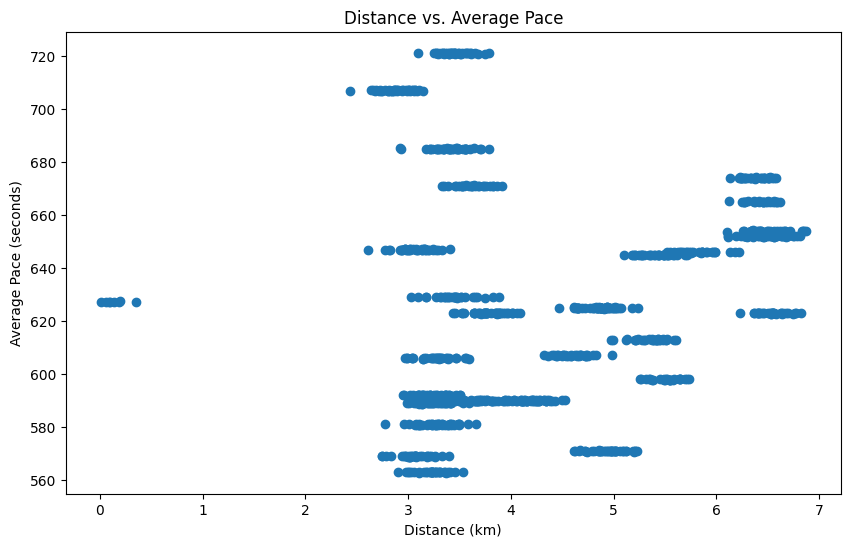

In [185]:
# Scatter Plot of Distance vs. Average Pace
# Scatter Plots: To explore relationships between features. 
plt.figure(figsize=(10, 6))
plt.scatter(running_data['Distance (km)'], running_data['Average Pace (seconds)'])
plt.title('Distance vs. Average Pace')
plt.xlabel('Distance (km)')
plt.ylabel('Average Pace (seconds)')
plt.show()

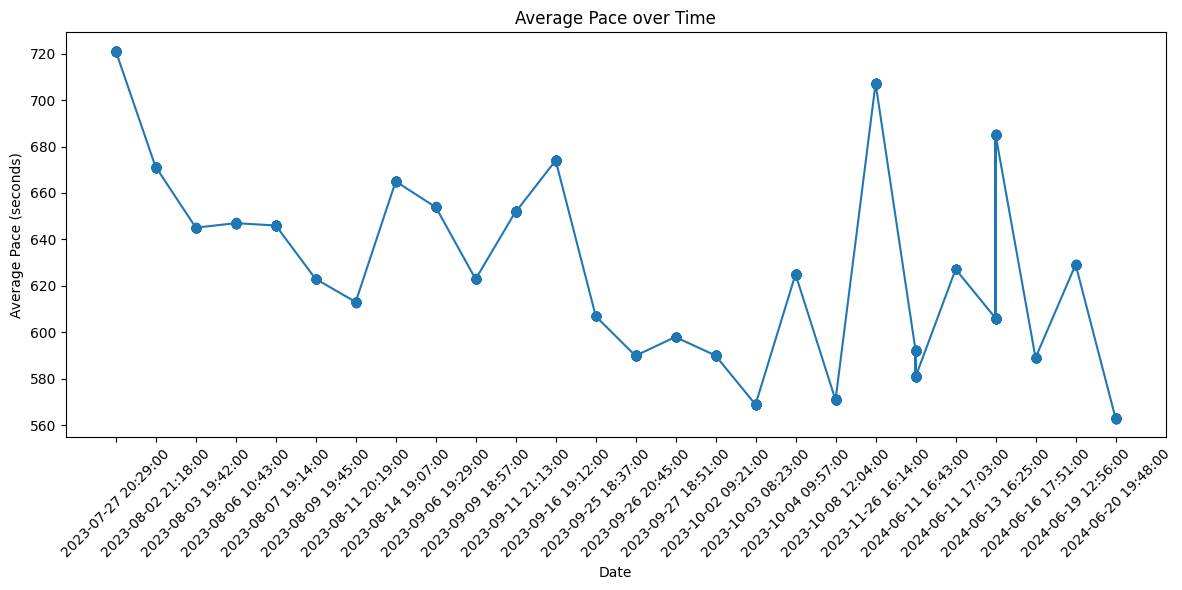

In [186]:
# Line Plot of Average Pace over Time
# Line Plots: To visualize trends over time.
plt.figure(figsize=(12, 6))
plt.plot(running_data['Date'], running_data['Average Pace (seconds)'], marker='o')
plt.title('Average Pace over Time')
plt.xlabel('Date')
plt.ylabel('Average Pace (seconds)')

# Rotate and format x-axis labels
plt.xticks(rotation=45)
ax = plt.gca()

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

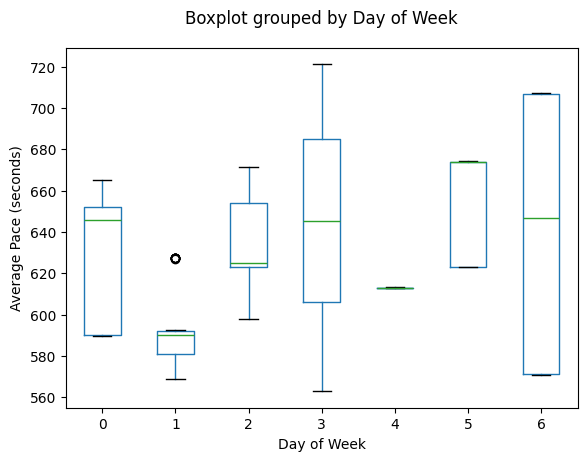

In [187]:
# Box Plots of Average Pace by Day of Week
# Box Plots: To identify outliers and distributions across different categories.
plt.figure(figsize=(10, 6))
running_data.boxplot(column='Average Pace (seconds)', by='Day of Week', grid=False)
plt.title('')
plt.xlabel('Day of Week')
plt.ylabel('Average Pace (seconds)')
plt.show()

In [188]:
# Load the Cleaned data
running_data = pd.read_csv('cleaned_running_data.csv')

In [189]:
# Define features and target
features = ['Time Since Last Run', 'Rolling Average Pace', 'Rolling Average Distance', 'Average Heart Rate (bpm)', 'Day of Week']
target = 'Distance (km)' # or 'Average Pace', depending on the goal

X = running_data[features]
y = running_data[target]

# Display the first few rows of features and target to confirm
print(X.head())
print(y.head())

   Time Since Last Run  Rolling Average Pace  Rolling Average Distance  \
0                    0            720.899140                  3.404045   
1                    0            720.916372                  3.415517   
2                    0            720.954853                  3.393368   
3                    0            720.966137                  3.433517   
4                    0            721.037352                  3.467810   

   Average Heart Rate (bpm)  Day of Week  
0                156.683715            3  
1                156.473129            3  
2                156.606605            3  
3                156.580187            3  
4                156.640525            3  
0    3.519049
1    3.272326
2    3.323948
3    3.583005
4    3.289961
Name: Distance (km), dtype: float64


In [190]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the sizes of the training and testing sets to confirm
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (798, 5)
Testing set size: (200, 5)


In [198]:
from sklearn.preprocessing import StandardScaler
import joblib

# Scale the features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Display the first few rows of scaled training data to confirm
print("First 5 rows of scaled training data:", X_train_scaled[:5])

First 5 rows of scaled training data: [[-0.0464747  -0.98524532 -0.80844394  0.27973348 -0.77023563]
 [-0.0464747   0.63877232  1.78417216 -0.46400655 -0.27254492]
 [-0.0464747   0.4418791   1.16808362  0.27208864 -1.26792635]
 [-0.0464747   0.02687034 -0.60752935  0.42469253 -0.27254492]
 [-0.0464747  -0.7318667   0.91892125  1.10627268 -0.27254492]]


In [199]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [200]:
# Build the neural network 
model = Sequential()

# First hidden layer
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.2))  # Dropout layer for regularization

# Second hidden layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))  # Single output for regression

# Compile the model
model.compile(optimizer='Adam', loss='mse')

c:\Users\PJ\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [201]:
# Early stopping callback
early_stopping = EarlyStopping(monitor= 'val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=200, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 19.5618 - val_loss: 13.8336
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13.0531 - val_loss: 7.6174
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4106 - val_loss: 3.1983
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2356 - val_loss: 1.4500
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7962 - val_loss: 1.0401
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0422 - val_loss: 0.8738
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9108 - val_loss: 0.7535
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4605 - val_loss: 0.6529
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4700 - val_loss: 0.6062
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3733 - val_loss: 0.5390
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5510 - val_loss: 0.4881
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss:

In [202]:
from sklearn.metrics import mean_absolute_error, r2_score

# Make predictions on the testing set
y_pred = model.predict(X_test_scaled)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate additional metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Mean Squared Error: 0.23281831054870308
Mean Absolute Error: 0.26719988323325405
R-squared: 0.8714610378497815


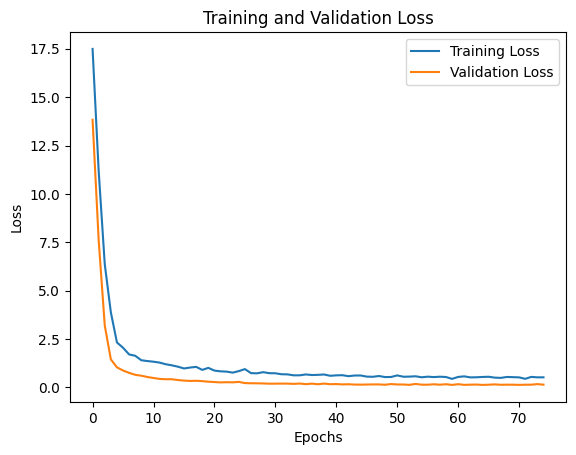

In [203]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')    
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [204]:
# Save the trained model
model.save('running_model.keras')